# 0 Import Packages

In [1]:
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import gpplot as gpp
import statistics 
import numpy as np
from poola import core as pool
from scipy import stats
import scipy as sp

warnings.filterwarnings("ignore")
sns.set(style="white", font_scale=1.5,font='arial')


### The secondary library consists of the following 4 designs. 

#### Subset 1 
- We identified the union of resistant hits (Z-score > 2) and sensitized hit (Z-score < -2) across VP64 and p65 for untreated and selumetinib modifiers. There are 529 total hits. We replicated all the hits in their original triple guide construct. 
- 529 total hits x 2 Sets x 2 TSS designs = 2116 constructs with three guides per construct 

#### Subset 2 
- We identified all the individual guides identified in the total 529 hits.
2 Sets x 2 TSS designs x 529 total hits x 3 guides - 925 duplicate guides = 5423 constructs with one guide per construct 
- Some guides are included in both the narrow and wide libraries which results in some duplicate guides when splitting triple guides constructs into individual guides

#### Subset 3
- We identified the overlapping hits between vp64 and p65 in the Selumetinib resistant, Selumetinib sensitize, viability resistant, and viability sensitize. Together those four categories sum to 142 overlapping hits. We designed all possible permutations of the triple guides for the overlapping hits. 
- (6 total permutation - 1 permutation already accounted for in subset 1 ) x 142 overlap hits x 2 sets x 2 TSS design = 2840 constructs with three guides per construct 

#### Subset 4
- We designed all possible permutations of the double guides for the 142 overlapping hits.
6 total permutations x 142 overlap hits  x 2 sets x 2 TSS design = 3408 constructs with two  guides per construct


### Note What is fillers?
- For construct with less than three guides, filler sequence is used to fill in the remaining space.  

## Required Files 
- Supplementary Data 5
- Supplementary Data 3
- Design outputs 
- Secondary Screen Design files
- Primary Screen processed data

In [3]:
path = ('../../manuscript data/Supplementary Data Files')

In [4]:
def z_score_neg_ctl(df, gene_col, lfc_col, z_col):
    neg_gene_df = df[df['Construct IDs'].str.contains('GUIDE_INTERGENIC_SITE') == True]
    neg_gene_df = neg_gene_df.dropna()
    neg_gene_mean = statistics.mean(neg_gene_df[lfc_col])
    neg_gene_sd = statistics.stdev(neg_gene_df[lfc_col])
    df[z_col] = (df[lfc_col] - neg_gene_mean)/neg_gene_sd
    return(df)


# 1.1 Caculate LFC for MELJUSO Data 

In [5]:
anno = pd.read_excel(path + '/Supplementary Data 5.xlsx', 'Library annotation')
anno.head()

Guide 1 DR_v2 Guide 2 DR_v3 Guide 3  \
0  ACGACAATCCAGATCGATCTTCT   NaN     NaN   NaN     NaN   
1  GCGGCCGGAACTATCCATACAGC   NaN     NaN   NaN     NaN   
2  GCGCGCTGGATCGGTGATAGCAT   NaN     NaN   NaN     NaN   
3  AACGGCGAATGGCCGCGTCTACA   NaN     NaN   NaN     NaN   
4  GAACGTGGGCCCGCGTCATGGTG   NaN     NaN   NaN     NaN   

                      Gene Symbol  
0  SINGLE_GUIDE_INTERGENIC_SITE_1  
1  SINGLE_GUIDE_INTERGENIC_SITE_2  
2  SINGLE_GUIDE_INTERGENIC_SITE_3  
3  SINGLE_GUIDE_INTERGENIC_SITE_4  
4  SINGLE_GUIDE_INTERGENIC_SITE_5

In [6]:
rc_meijuso = pd.read_excel(path + '/Supplementary Data 5.xlsx', 'Meljuso', 
                             skiprows=2, names = ['Construct IDs', 'VP64 pDNA', 'p65 pDNA', 
                                                  'VP64_Untreated_repA', 'VP64_Untreated_repB',
                                                 'VP64_Selumetinib_repA', 'VP64_Selumetinib_repB',
                                                 'p65_Untreated_repA', 'p65_Untreated_repB',
                                                 'p65_Selumetinib_repA', 'p65_Selumetinib_repB'])



In [7]:
vp64_col = [col for col in rc_meijuso.columns if 'VP64' in col]
p65_col = [col for col in rc_meijuso.columns if 'p65' in col]

In [8]:
rc_meijuso = pd.concat([anno, rc_meijuso], axis="columns")

In [9]:
rc_meijuso_lognorm = pool.lognorm_columns(reads_df=rc_meijuso, columns=[ 'VP64 pDNA', 'p65 pDNA', 
 'VP64_Untreated_repA', 'VP64_Untreated_repB',
 'VP64_Selumetinib_repA', 'VP64_Selumetinib_repB',
 'p65_Untreated_repA', 'p65_Untreated_repB',
 'p65_Selumetinib_repA', 'p65_Selumetinib_repB'])

# Code from poola filter_pdna: https://github.com/gpp-rnd/poola/blob/master/poola/core.py 
# this will flag the construct to eliminate later
flag_filtered_lognorms = rc_meijuso_lognorm.copy()
for pdna in ['VP64 pDNA', 'p65 pDNA']:
    z_col = pdna + '_z'
    flag_filtered_lognorms[z_col] = (flag_filtered_lognorms[pdna] - flag_filtered_lognorms[pdna].mean())/flag_filtered_lognorms[pdna].std()

In [10]:
# Viability LFC
lfc_MELJUSO_vp64_via_from_pDNA = pool.calculate_lfcs(lognorm_df=flag_filtered_lognorms, ref_col='VP64 pDNA', 
                             target_cols=['VP64_Untreated_repA', 'VP64_Untreated_repB'])

lfc_MELJUSO_via_from_pDNA = pool.calculate_lfcs(lognorm_df=lfc_MELJUSO_vp64_via_from_pDNA, ref_col='p65 pDNA', 
                             target_cols=['p65_Untreated_repA', 'p65_Untreated_repB'])

#Sel
#calculating lfc from dropout
lfc_MELJUSO_vp64_sel_from_dropout_repA = pool.calculate_lfcs(lognorm_df=flag_filtered_lognorms, ref_col='VP64_Untreated_repA', 
                             target_cols=['VP64_Selumetinib_repA'])
lfc_MELJUSO_vp64_sel_from_dropout_repB = pool.calculate_lfcs(lognorm_df=lfc_MELJUSO_vp64_sel_from_dropout_repA, ref_col='VP64_Untreated_repB', 
                             target_cols=['VP64_Selumetinib_repB'])

#calculating lfc from dropout
lfc_MELJUSO_p65_sel_from_dropout_repA = pool.calculate_lfcs(lognorm_df=lfc_MELJUSO_vp64_sel_from_dropout_repB, ref_col='p65_Untreated_repA', 
                             target_cols=['p65_Selumetinib_repA'])
lfc_MELJUSO_sel_from_dropout = pool.calculate_lfcs(lognorm_df=lfc_MELJUSO_p65_sel_from_dropout_repA, ref_col='p65_Untreated_repB', 
                             target_cols=['p65_Selumetinib_repB'])


In [11]:
lfc_MELJUSO = pd.concat([lfc_MELJUSO_sel_from_dropout, 
           lfc_MELJUSO_via_from_pDNA[['VP64_Untreated_repA', 'VP64_Untreated_repB','p65_Untreated_repA', 'p65_Untreated_repB']]], axis = 1)

In [12]:
lfc_MELJUSO

Guide 1                 DR_v2                  Guide 2  \
0      ACGACAATCCAGATCGATCTTCT                   NaN                      NaN   
1      GCGGCCGGAACTATCCATACAGC                   NaN                      NaN   
2      GCGCGCTGGATCGGTGATAGCAT                   NaN                      NaN   
3      AACGGCGAATGGCCGCGTCTACA                   NaN                      NaN   
4      GAACGTGGGCCCGCGTCATGGTG                   NaN                      NaN   
...                        ...                   ...                      ...   
14782  CCGGGGACCTAGGAAATGAGCAG  TAATTTCTACTATCGTAGAT  ATCCTACCTACGTGTGAAAATTG   
14783  CTCCGTTCAATGTCATAAGAAAC  TAATTTCTACTATCGTAGAT  GCAATGATCCACAACTAGGCAGG   
14784  TGGTAGCCCATATGCCAGCCAGG  TAATTTCTACTATCGTAGAT  TGTTAGGACTATCGGTGGGAAGG   
14785  TCGTCCTCCACGCATAGTGTCTA  TAATTTCTACTATCGTAGAT  AAGCAAACCCTGATACGATCCAA   
14786  GGTGCTCTTGAGTAGGGACAGTC  TAATTTCTACTATCGTAGAT  CAATATCACCGTACCTATTTAAT   

                      DR_v3                  Guide 3  \
0                       NaN                      NaN   
1                       NaN                      NaN   
2                       NaN                      NaN   
3                       NaN                      NaN   
4                       NaN                      NaN   
...                     ...                      ...   
14782  AAATTTCTACTCTAGTAGAT  CCCTTCGGGCTAGAAGGAGGGCT   
14783  AAATTTCTACTCTAGTAGAT  AATACCATCCGTTATGGGTTAAA   
14784  AAATTTCTACTCTAGTAGAT  CTACGTTGGAGAAGTGCAGTATT   
14785  AAATTTCTACTCTAGTAGAT  GTCTAGAAGAAGGACCCTTTAAC   
14786  AAATTTCTACTCTAGTAGAT  TAGCACCCAGCCCGATGGGCATG   

                             Gene Symbol  \
0         SINGLE_GUIDE_INTERGENIC_SITE_1   
1         SINGLE_GUIDE_INTERGENIC_SITE_2   
2         SINGLE_GUIDE_INTERGENIC_SITE_3   
3         SINGLE_GUIDE_INTERGENIC_SITE_4   
4         SINGLE_GUIDE_INTERGENIC_SITE_5   
...                                  ...   
14782   TRIPLE_GUIDE_INTERGENIC_SITE_996   
14783   TRIPLE_GUIDE_INTERGENIC_SITE_997   
14784   TRIPLE_GUIDE_INTERGENIC_SITE_998   
14785   TRIPLE_GUIDE_INTERGENIC_SITE_999   
14786  TRIPLE_GUIDE_INTERGENIC_SITE_1000   

                                           Construct IDs  VP64 pDNA  p65 pDNA  \
0           SINGLE_GUIDE_INTERGENIC_SITE_1;Filler;Filler   6.586991  6.551709   
1           SINGLE_GUIDE_INTERGENIC_SITE_2;Filler;Filler   5.869560  6.210093   
2           SINGLE_GUIDE_INTERGENIC_SITE_3;Filler;Filler   5.904873  6.118282   
3           SINGLE_GUIDE_INTERGENIC_SITE_4;Filler;Filler   5.490109  5.248823   
4           SINGLE_GUIDE_INTERGENIC_SITE_5;Filler;Filler   6.527817  6.559488   
...                                                  ...        ...       ...   
14782  TRIPLE_GUIDE_INTERGENIC_SITE_996;TRIPLE_GUIDE_...   5.939342  5.902845   
14783  TRIPLE_GUIDE_INTERGENIC_SITE_997;TRIPLE_GUIDE_...   5.808714  5.950951   
14784  TRIPLE_GUIDE_INTERGENIC_SITE_998;TRIPLE_GUIDE_...   6.272419  6.277669   
14785  TRIPLE_GUIDE_INTERGENIC_SITE_999;TRIPLE_GUIDE_...   6.110438  6.314909   
14786  TRIPLE_GUIDE_INTERGENIC_SITE_1000;TRIPLE_GUIDE...   5.474524  5.589974   

       VP64_Selumetinib_repA  VP64_Selumetinib_repB  p65_Selumetinib_repA  \
0                   0.527685               0.363616              0.399584   
1                  -0.149636              -0.562560             -0.539745   
2                  -0.131415               0.174997             -0.510847   
3                  -0.896526              -0.124391             -0.353339   
4                  -0.495070              -0.592488             -0.532152   
...                      ...                    ...                   ...   
14782              -0.331323              -0.385151             -0.351860   
14783               0.178722              -0.088362             -0.071100   
14784              -0.060281              -0.273852             -0.016703   
14785               0.006222              -0.467593             -0.712380   
14786              -0.358837

In [13]:
lfc_MELJUSO['avg_lfc_vp64_via'] = lfc_MELJUSO[['VP64_Untreated_repA', 'VP64_Untreated_repB']].mean(axis=1)

lfc_MELJUSO['avg_lfc_vp64_sel'] = lfc_MELJUSO[['VP64_Selumetinib_repB', 'VP64_Selumetinib_repA']].mean(axis=1)

lfc_MELJUSO['avg_lfc_p65_via'] = lfc_MELJUSO[['p65_Untreated_repA', 'p65_Untreated_repB']].mean(axis=1)

lfc_MELJUSO['avg_lfc_p65_sel'] = lfc_MELJUSO[['p65_Selumetinib_repB', 'p65_Selumetinib_repA']].mean(axis=1)
lfc_MELJUSO['guide'] = lfc_MELJUSO[['Guide 1', 'DR_v2', 'Guide 2', 'DR_v3', 'Guide 3']].stack().groupby(level=0).agg(''.join)


## 1.2 correlation heatplot of LFC

In [14]:

lfc_MELJUSO_merged = lfc_MELJUSO[(lfc_MELJUSO['VP64 pDNA_z'] > -3) & (lfc_MELJUSO['p65 pDNA_z'] > -3)]
print('Filtered ' + str(lfc_MELJUSO.shape[0] - lfc_MELJUSO_merged.shape[0]) + ' rows due to low pDNA abundance')

Filtered 88 rows due to low pDNA abundance


In [15]:

lfc_MELJUSO_merged = lfc_MELJUSO_merged[['Gene Symbol','Construct IDs','Guide 1', 'DR_v2', 'Guide 2', 'DR_v3', 'Guide 3',  
 'VP64 pDNA', 'p65 pDNA',  'VP64_Untreated_repA',
       'VP64_Untreated_repB', 'p65_Untreated_repA', 'p65_Untreated_repB',
 'VP64_Selumetinib_repA', 'VP64_Selumetinib_repB', 
 'p65_Selumetinib_repA', 'p65_Selumetinib_repB']]



Text(0.5, 1.0, 'Replicates LFC Correlation MELJUSO Viability')

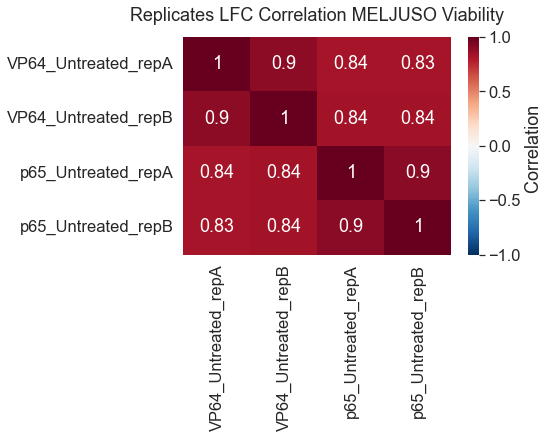

In [16]:
reps_col_name = [col for col in lfc_MELJUSO_merged.columns if 'Untreated_repA' in col or 'Untreated_repB' in col]

heatmap = sns.heatmap(lfc_MELJUSO_merged[reps_col_name].corr(), vmin=-1, vmax=1, annot=True,  
                      cmap=gpp.diverging_cmap(), center = 0, 
                   cbar_kws={'label':'Correlation '})
heatmap.set_title('Replicates LFC Correlation MELJUSO Viability', 
                  fontdict={'fontsize':18}, pad=16)

In [17]:
reps_col_name = [col for col in lfc_MELJUSO_merged.columns if 'Selumetinib_repA' in col or 'Selumetinib_repB' in col]

heatmap = sns.heatmap(lfc_MELJUSO_merged[reps_col_name].corr(), vmin=-1, vmax=1, annot=True,  
                      cmap=gpp.diverging_cmap(), center = 0, 
                   cbar_kws={'label':'Correlation '})
heatmap.set_title('Replicates LFC Correlation MELJUSO Viability', 
                  fontdict={'fontsize':18}, pad=16)

Text(0.5, 1.0, 'Replicates LFC Correlation MELJUSO Viability')

# 1.3 MELJUSO construct z-score

In [18]:
#VP64 and p65 have different pDNA filtered and want to perserve construct that doesn't exceed it in both
# use or operater, want to keep as much data as possible
lfc_MELJUSO_outer_merged = lfc_MELJUSO[(lfc_MELJUSO['VP64 pDNA_z'] > -3) | (lfc_MELJUSO['p65 pDNA_z'] > -3)]
print('Filtered ' + str(lfc_MELJUSO.shape[0] - lfc_MELJUSO_outer_merged.shape[0]) + ' rows due to low pDNA abundance')

Filtered 44 rows due to low pDNA abundance


In [19]:
# set NA for construct with pDNA <-3
for activtor in ['VP64', 'p65']:
    lfc_MELJUSO_outer_merged.loc[lfc_MELJUSO_outer_merged[activtor+' pDNA_z'] < -3, 'avg_lfc_'+activtor.lower()+'_via'] = np.NaN
    lfc_MELJUSO_outer_merged.loc[lfc_MELJUSO_outer_merged[activtor+' pDNA_z'] < -3, 'avg_lfc_'+activtor.lower()+'_sel'] = np.NaN

In [20]:
lfc_MELJUSO_outer_merged = lfc_MELJUSO_outer_merged[['Gene Symbol',
                          'Construct IDs', 'avg_lfc_vp64_via', 'avg_lfc_vp64_sel', 
                          'avg_lfc_p65_via','avg_lfc_p65_sel', 'guide']]

In [21]:
z_MELJUSO = z_score_neg_ctl(lfc_MELJUSO_outer_merged, 'Construct IDs', 'avg_lfc_vp64_via', 'z_vp64_via')
z_MELJUSO = z_score_neg_ctl(z_MELJUSO, 'Construct IDs', 'avg_lfc_p65_via', 'z_p65_via')
z_MELJUSO = z_score_neg_ctl(z_MELJUSO, 'Construct IDs', 'avg_lfc_p65_sel', 'z_p65_sel')
z_MELJUSO = z_score_neg_ctl(z_MELJUSO, 'Construct IDs', 'avg_lfc_vp64_sel', 'z_vp64_sel')


# 1.4 MELJUSO Data Quality Comparing to Primary Screen

Following section is analysed using Subset 1 data as described above

In [22]:
# this is primary screen data, data is from the processed data files --primary screen processed data
df_p65_untreated = pd.read_csv('../../manuscript data/primary screen processed data/oligo_p65_via_z.csv')
df_p65_sel = pd.read_csv('../../manuscript data/primary screen processed data/oligo_p65_sel_z.csv')

df_vp64_untreated = pd.read_csv('../../manuscript data/primary screen processed data/oligo_vp64_via_z.csv')
df_vp64_sel = pd.read_csv('../../manuscript data/primary screen processed data/oligo_vp64_sel_z.csv')

df_p65_untreated['type'] = 'p65_untreated'
df_p65_sel['type'] = 'p65_sel'
df_vp64_untreated['type'] = 'vp64_untreated'
df_vp64_sel['type'] = 'vp64_sel'

primary_screen = pd.concat([df_p65_untreated, df_p65_sel, df_vp64_untreated, df_vp64_sel])

DR2 = primary_screen.DR_v2[0].tolist()[0]
DR3 = primary_screen.DR_v3[0].tolist()[0]

primary_screen.DR_v2 = DR2
primary_screen.DR_v3 = DR3

primary_screen['guide'] = primary_screen['Guide 1'] + primary_screen['DR_v2'] + primary_screen['Guide 2'] + primary_screen['DR_v3'] + primary_screen['Guide 3']


In [23]:
# combining primary and secondary screen 
sub1_comb = pd.merge(primary_screen[['guide', 'Gene Symbol', 'Design window', 'Set', 'type','z_scored_olfactory_gene']],
                     z_MELJUSO,
                     on = 'guide' )


In [24]:

sub1_comb_melt = (sub1_comb.melt(id_vars=list(set(sub1_comb.columns) ^ set(['z_vp64_via', 'z_p65_via', 'z_p65_sel',
       'z_vp64_sel'])),
                         var_name='secondary cond', value_name='secondary z-score'))

#matching primary conditions to secondary conditions
plot_primary_secondary = sub1_comb_melt[((sub1_comb_melt.type == 'p65_untreated') & (sub1_comb_melt['secondary cond'] == 'z_p65_via')) | 
                                        ((sub1_comb_melt.type == 'p65_sel') & (sub1_comb_melt['secondary cond'] == 'z_p65_sel')) | 
                                        ((sub1_comb_melt.type == 'vp64_sel') & (sub1_comb_melt['secondary cond'] == 'z_vp64_sel')) | 
                                        ((sub1_comb_melt.type == 'vp64_untreated') & (sub1_comb_melt['secondary cond'] == 'z_vp64_via'))]

Text(0, 0.5, 'Secondary Z-score')

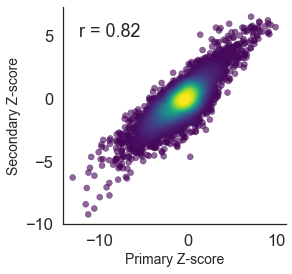

In [25]:
fig, ax = plt.subplots(figsize=(4,4))
ax = gpp.point_densityplot(plot_primary_secondary.dropna(), "z_scored_olfactory_gene", "secondary z-score", palette=gpp.sequential_cmap(), ax=ax)
ax = gpp.add_correlation(plot_primary_secondary.dropna(), "z_scored_olfactory_gene", "secondary z-score", method ='pearson')
sns.despine()
plt.xlabel('Primary Z-score',fontsize=14)
plt.ylabel('Secondary Z-score',fontsize=14)


# 1.5 High confidence genes

### genes with 4 constructs (VP64 sel, VP64 resist, p65 sel, p65 resist) and an absolute z-score greater than 2 in both TADs

In [26]:
all_drugarm_validate = pd.read_excel(path + '/Supplementary Data 5.xlsx', 'High confidence gene set')
all_drugarm_validate = all_drugarm_validate.melt(var_name='drugarm_direction', value_name='g1').dropna()


In [27]:
all_drugarm_validate[['drugarm','Gene Direction']] = all_drugarm_validate['drugarm_direction'].str.split(' ',expand=True)[[0,1]]

In [28]:
all_drugarm_validate

drugarm_direction       g1      drugarm Gene Direction
0    Selumetinib Resistance Gene     BRAF  Selumetinib     Resistance
1    Selumetinib Resistance Gene   FBXL22  Selumetinib     Resistance
2    Selumetinib Resistance Gene     NAV3  Selumetinib     Resistance
3    Selumetinib Resistance Gene     NRAS  Selumetinib     Resistance
4    Selumetinib Resistance Gene     RAF1  Selumetinib     Resistance
5    Selumetinib Resistance Gene    TTC14  Selumetinib     Resistance
9   Selumetinib Sensitizing Gene    DUSP6  Selumetinib    Sensitizing
10  Selumetinib Sensitizing Gene    GATA6  Selumetinib    Sensitizing
11  Selumetinib Sensitizing Gene   GPBAR1  Selumetinib    Sensitizing
12  Selumetinib Sensitizing Gene   SRGAP3  Selumetinib    Sensitizing
13  Selumetinib Sensitizing Gene     TLE3  Selumetinib    Sensitizing
27    Viability Sensitizing Gene   CDKN1A    Viability    Sensitizing
28    Viability Sensitizing Gene   CDKN1C    Viability    Sensitizing
29    Viability Sensitizing Gene   CDKN2C    Viability    Sensitizing
30    Viability Sensitizing Gene   EEF1A1    Viability    Sensitizing
31    Viability Sensitizing Gene     JUNB    Viability    Sensitizing
32    Viability Sensitizing Gene  MAP3K11    Viability    Sensitizing
33    Viability Sensitizing Gene    NCEH1    Viability    Sensitizing
34    Viability Sensitizing Gene    PRDM1    Viability    Sensitizing
35    Viability Sensitizing Gene    UIMC1    Viability    Sensitizing

# 2 single guide analysis 

The following section is using subset 2 data as described above.

In [29]:
# Annotation design files; wide and narrow
lib_825 = pd.read_csv('../../manuscript data/Guide Design Files/wide_tss_sgrna_design.csv')
lib_300 = pd.read_csv('../../manuscript data/Guide Design Files/narrow_tss_sgrna_design.csv')
cas12a_key = pd.concat([lib_825[['sgRNA Sequence','Target Gene Symbol','sgRNA \'Cut\' Site TSS Offset','On-Target Ruleset','On-Target Efficacy Score']],
          lib_300[['sgRNA Sequence','Target Gene Symbol','sgRNA \'Cut\' Site TSS Offset','On-Target Ruleset','On-Target Efficacy Score']]]).drop_duplicates()


In [30]:
z_MELJUSO[['g1', 'g2','g3']] =z_MELJUSO['Construct IDs'].str.split(';',expand=True)[[0,1,2]]

In [31]:
single_guide = z_MELJUSO[(z_MELJUSO['g2'] == 'Filler') & (z_MELJUSO['g3'] == 'Filler')]
single_guide = single_guide[single_guide['Construct IDs'].str.contains('GUIDE_INTERGENIC_SITE') == False]
single_guide = single_guide[['g1', 'guide', 'z_vp64_via','z_p65_via', 'z_p65_sel', 'z_vp64_sel']]

In [32]:
validated_guides = single_guide[single_guide.g1.isin(all_drugarm_validate.g1)]
validated_guides = validated_guides.merge(all_drugarm_validate[['g1', 'drugarm','Gene Direction']].drop_duplicates(), on ='g1')


In [33]:
validated_guides = pd.merge(validated_guides
         .rename(columns = {'g1': 'Target Gene Symbol','guide': 'sgRNA Sequence'}), 
         cas12a_key, on = ['sgRNA Sequence', 'Target Gene Symbol'])
validated_guides

Target Gene Symbol           sgRNA Sequence  z_vp64_via  z_p65_via  \
0                UIMC1  CCCCAAAGCGCAAGCAACTGAGA   -2.313342  -2.158446   
1                UIMC1  CCCAAAGCGCAAGCAACTGAGAC   -1.817633  -2.132247   
2                UIMC1  AGTCTCCGCGCGCTGCGCCTGCG   -0.761690  -0.869029   
3                UIMC1  CCCCACAGCTATCTCTGAGTCTG   -2.511493  -1.607691   
4                UIMC1  AACTGCGCGGGAGGCGCTGACCG    0.912671   0.803444   
..                 ...                      ...         ...        ...   
197             FBXL22  AGGAAAGTAACTTCAATAGGCTC    3.392812   2.645016   
198             FBXL22  TGCCAGGACCTCCAATCCCTCTG    1.070368   1.023599   
199             FBXL22  GCCAGGACCTCCAATCCCTCTGA    1.848913   1.441048   
200             FBXL22  TCTGGAAGGCACTCTTGAGCCAG    0.459066   0.634002   
201             FBXL22  CCGGCTGCAGCTGCACTCACATG   -0.326169  -0.600925   

     z_p65_sel  z_vp64_sel      drugarm Gene Direction  \
0     0.326197    2.129391    Viability    Sensitizing   
1     0.444707    0.691108    Viability    Sensitizing   
2     0.277137   -1.099488    Viability    Sensitizing   
3    -0.245071    1.938137    Viability    Sensitizing   
4    -0.030785    0.357926    Viability    Sensitizing   
..         ...         ...          ...            ...   
197   1.373566    1.839931  Selumetinib     Resistance   
198  -1.370994   -0.504695  Selumetinib     Resistance   
199  -0.219877    0.070364  Selumetinib     Resistance   
200   0.139813    0.577182  Selumetinib     Resistance   
201  -0.377531   -0.109126  Selumetinib     Resistance   

     sgRNA 'Cut' Site TSS Offset On-Target Ruleset  On-Target Efficacy Score  
0                           -115          enPAM+GB                    0.8565  
1                           -114          enPAM+GB                    0.7537  
2                             -1          enPAM+GB                    0.7997  
3                           -156          enPAM+GB                    0.8397  
4                            -83          enPAM+GB                    0.5201  
..                           ...               ...                       ...  
197                         -221          enPAM+GB                    0.9151  
198                         -192          enPAM+GB                    0.9215  
199                         -191          enPAM+GB                    0.6146  
200                          276          enPAM+GB                    0.8082  
201                            6          enPAM+GB                    0.6667  

[202 rows x 11 columns]

# 2.2 Can we use RS to pick guides? Figure 5 d

### Note: Each plot is only using high confidence genes 


In [34]:

validated_guides['avg_z_via'] = validated_guides[['z_vp64_via', 'z_p65_via']].mean(axis=1)
validated_guides['avg_z_sel'] = validated_guides[['z_vp64_sel', 'z_p65_sel']].mean(axis=1)

Low Active       109
Highly Active     51
Median Active     42
Name: active level, dtype: int64


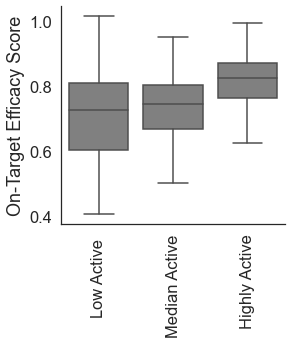

In [35]:

boxplot_act_level = (validated_guides[['sgRNA Sequence', 'Target Gene Symbol',  'drugarm', 'Gene Direction',
       'On-Target Efficacy Score', 'avg_z_via', 'avg_z_sel']].melt(
    id_vars=['sgRNA Sequence', 'Target Gene Symbol','drugarm','Gene Direction','On-Target Efficacy Score'],
                         var_name='z_drugarm', value_name='z-score'))
boxplot_act_level = boxplot_act_level[((boxplot_act_level.drugarm == 'Viability') & (boxplot_act_level.z_drugarm == 'avg_z_via')) | 
                                      ((boxplot_act_level.drugarm == 'Selumetinib') & (boxplot_act_level.z_drugarm == 'avg_z_sel'))]

conditions  = [ (abs(boxplot_act_level['z-score'])>2), 
               ((abs(boxplot_act_level['z-score'])<= 2) & (abs(boxplot_act_level['z-score'])>1)), 
               (abs(boxplot_act_level['z-score'])<= 1)]
choices = [ "Highly Active", 'Median Active', 'Low Active ']

boxplot_act_level["active level"] = np.select(conditions, choices)
plot = boxplot_act_level[['Target Gene Symbol', 'On-Target Efficacy Score','drugarm', 'active level']].dropna()
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.boxplot(data=plot.dropna(), x='active level', y="On-Target Efficacy Score", 
                         order = [ 'Low Active ', 'Median Active', "Highly Active"],color = 'grey',ax=ax)
print(plot['active level'].value_counts())
ax.title.set_text('' )
ax.set(xlabel='')
ax.tick_params(axis='x', rotation=90)

sns.despine()


# 2.3 Tss vs single guide  Figure 5 e

In [36]:
tss_act_level = (validated_guides[['sgRNA Sequence', 'Target Gene Symbol',  'drugarm', 'Gene Direction',
       'On-Target Efficacy Score', 'avg_z_via', 'avg_z_sel',"sgRNA 'Cut' Site TSS Offset"]].melt(
    id_vars=['sgRNA Sequence', 'Target Gene Symbol', 'drugarm','Gene Direction','On-Target Efficacy Score',"sgRNA 'Cut' Site TSS Offset"],
                         var_name='z_drugarm', value_name='z-score'))



tss_act_level = tss_act_level[((tss_act_level.drugarm == 'Viability') & (tss_act_level.z_drugarm == 'avg_z_via')) | ((tss_act_level.drugarm == 'Selumetinib') & (tss_act_level.z_drugarm == 'avg_z_sel'))]


conditions_guide_rank  = [ (abs(tss_act_level['z-score'])>2), 
               ((abs(tss_act_level['z-score'])<= 2) & (abs(tss_act_level['z-score'])>1)), 
               (abs(tss_act_level['z-score'])<= 1)
              ]

choices_guide_rank     = [ "Highly Active", 'Median Active', 'Low Active']
tss_act_level["active level"] = np.select(conditions_guide_rank, choices_guide_rank)

 
    # assign tss bucket to the guides targeting high confidence genes 
conditions_tss  = [ (tss_act_level["sgRNA 'Cut' Site TSS Offset"]>100), 
                   ((tss_act_level["sgRNA 'Cut' Site TSS Offset"]>0) & (tss_act_level["sgRNA 'Cut' Site TSS Offset"]<=100)), 
                   ((tss_act_level["sgRNA 'Cut' Site TSS Offset"]>-50) & (tss_act_level["sgRNA 'Cut' Site TSS Offset"]<=0)), 
                  ((tss_act_level["sgRNA 'Cut' Site TSS Offset"]>-100) & (tss_act_level["sgRNA 'Cut' Site TSS Offset"]<= -50)), 
                   ((tss_act_level["sgRNA 'Cut' Site TSS Offset"]>-150) & (tss_act_level["sgRNA 'Cut' Site TSS Offset"]<= -100)), 
                   ((tss_act_level["sgRNA 'Cut' Site TSS Offset"]>-200) & (tss_act_level["sgRNA 'Cut' Site TSS Offset"]<= -150)), 
                    ((tss_act_level["sgRNA 'Cut' Site TSS Offset"]>-250) & (tss_act_level["sgRNA 'Cut' Site TSS Offset"]<= -200)), 
                   (tss_act_level["sgRNA 'Cut' Site TSS Offset"]<= -250)]
choices_tss     = [ ">100",  '0 to 100',  '-50 to 0', '-100 to -50', '-150 to -100',  '-200 to -150',  '-250 to -200', ' <-250']

tss_act_level["TSS bin"] = np.select(conditions_tss, choices_tss)

    # help to put tss in order
value_sort = list(range(len(choices_tss),0,-1))
tss_act_level['tss_sort'] = np.select(conditions_tss, value_sort)

n_obs = []
for val in choices_tss:
    val_tss = tss_act_level[tss_act_level['TSS bin'] == val]
    total_val = len(val_tss)
    n_obs.append(total_val)
        
tss_act_level['n_obs'] = np.select(conditions_tss, n_obs)
tss_act_level = tss_act_level.sort_values('tss_sort').reset_index(level=0)
tss_act_level['TSS bin'] = tss_act_level['TSS bin'] + ';n = ' + tss_act_level['n_obs'].astype(str)
    
    
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.histplot(
        data=tss_act_level[['active level', 'TSS bin']],
        x="TSS bin", hue="active level",
        multiple="fill", stat="proportion",
        discrete=True, shrink=.8,hue_order=[ 'Low Active','Median Active',"Highly Active" ]
    )
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Relative distance from MANE Select TSS', ylabel='Fraction of Guides')
ax.set_ylim([0, 1])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


# 2.4 relationship between TSS and Cas12a CRISPRa on-target score;  Figure 5 f

In [37]:
tss_rs = (validated_guides[['sgRNA Sequence', 'Target Gene Symbol',  'drugarm', 'Gene Direction',
       'On-Target Efficacy Score', 'avg_z_via', 'avg_z_sel',"sgRNA 'Cut' Site TSS Offset"]].melt(
    id_vars=['sgRNA Sequence', 'Target Gene Symbol', 'drugarm','Gene Direction','On-Target Efficacy Score',"sgRNA 'Cut' Site TSS Offset"],
                         var_name='z_drugarm', value_name='z-score'))
tss_rs = tss_rs[((tss_rs.drugarm == 'Viability') & (tss_rs.z_drugarm == 'avg_z_via')) | ((tss_rs.drugarm == 'Selumetinib') & (tss_rs.z_drugarm == 'avg_z_sel'))]

conditions_guide_rank  = [ (abs(tss_rs['z-score'])>2), 
               ((abs(tss_rs['z-score'])<= 2) & (abs(tss_rs['z-score'])>1)), 
               (abs(tss_rs['z-score'])<= 1)
              ]

choices_guide_rank     = [ "Highly Active", 'Median Active', 'Low Active']
tss_rs["active level"] = np.select(conditions_guide_rank, choices_guide_rank)

 


In [38]:
threashold = tss_rs[tss_rs['active level'] == 'Highly Active'].quantile(0.25)['On-Target Efficacy Score']

# used the plot before to define TSS optimal region [-200, -100]
conditions_bin  = [
    ((tss_rs[ "sgRNA 'Cut' Site TSS Offset"] <= -100) & 
     (tss_rs[ "sgRNA 'Cut' Site TSS Offset"]>= -200) & 
     (tss_rs[ "On-Target Efficacy Score"] >= threashold)),
    ((tss_rs[ "sgRNA 'Cut' Site TSS Offset"] <= -100) & 
     (tss_rs[ "sgRNA 'Cut' Site TSS Offset"]>= -200) & 
     (tss_rs[ "On-Target Efficacy Score"] < threashold)),
               ((tss_rs[ "sgRNA 'Cut' Site TSS Offset"] > -100) | 
                (tss_rs[ "sgRNA 'Cut' Site TSS Offset"] < -200) & 
                (tss_rs[ "On-Target Efficacy Score"] >= threashold)),
               ((tss_rs[ "sgRNA 'Cut' Site TSS Offset"] > -100) | 
                (tss_rs[ "sgRNA 'Cut' Site TSS Offset"] < -200) & 
                (tss_rs[ "On-Target Efficacy Score"] < threashold))]

choices_bin     = [ "sgRNA 'Cut' Site TSS Offset: [-200, -100] & RS >= 0.76", 
                   "sgRNA 'Cut' Site TSS Offset: [-200, -100] & RS < 0.76",
                  "sgRNA 'Cut' Site TSS Offset: Otherwise & RS >= 0.76",
                  "sgRNA 'Cut' Site TSS Offset: Otherwise & RS < 0.76"]
tss_rs["RS level"] = np.select(conditions_bin, choices_bin)




[Text(0.5, 0, ''), Text(0, 0.5, 'Fraction of Guides')]

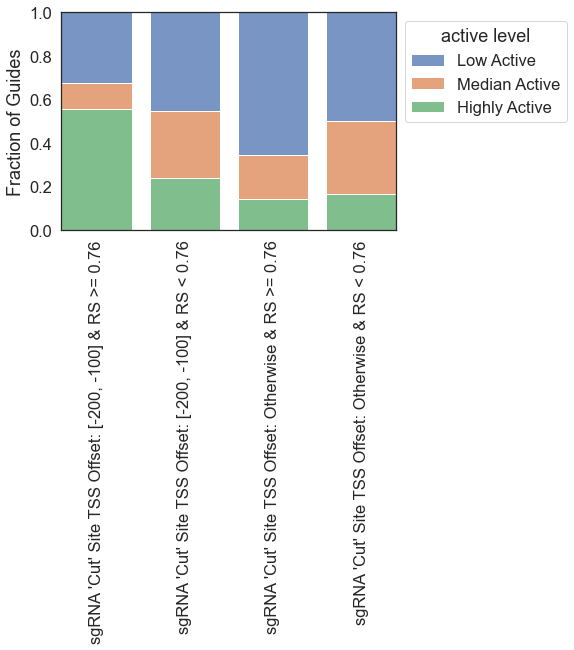

In [39]:
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.histplot(
        data=tss_rs[['active level', 'RS level']],
        x="RS level", hue="active level",
        multiple="fill", stat="proportion",
        discrete=True, shrink=.8,hue_order=[ 'Low Active','Median Active',"Highly Active" ])
ax.tick_params(axis='x', rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='', ylabel='Fraction of Guides')



# 3 Does order matter; Supple Figure 5 d
## 6 permutation x 2 sets x 2 tss

In [40]:
# union_3_guide is subset 1 as described above 
# shuffle_3_guide is subset 3 as described above 

union_3_guide = pd.read_csv('../../manuscript data/Secondary Screen Design files/union_triple_guide_oligo.csv')
shuffle_3_guide = pd.read_csv('../../manuscript data/Secondary Screen Design files/shuffle_triple_guide_oligo.csv')

supp_data_3 = pd.read_excel(path + '/Supplementary Data 3.xlsx', 'Library annotation')
supp_data_3.DR_v2 = DR2
supp_data_3.DR_v3 = DR3


In [41]:
union_3_guide['order'] = 'guide_1_guide_2_guide_3'
validated_guide_3 = pd.concat([union_3_guide[union_3_guide['Gene'].isin(shuffle_3_guide['Gene'])],shuffle_3_guide])

In [42]:
validated_guide_3_123 = pd.merge(supp_data_3,
           validated_guide_3[['Gene','guide_1', 'DR2', 'guide_2', 'DR3', 'guide_3','order']].rename(columns= {'Gene': 'Gene Symbol','guide_1':'Guide 1', 'DR2': 'DR_v2', 
                            'guide_2': 'Guide 2', 'DR3': 'DR_v3', 'guide_3': 'Guide 3'}))


In [43]:
validated_guide_3_123

Guide 1                 DR_v2                  Guide 2  \
0    GCCCGCCAGGAATTAACCTTGAC  TAATTTCTACTATCGTAGAT  AGAGAATGTTCAGAGACCTCAAC   
1    CCAACCACACCCGGCGCGCCCGA  TAATTTCTACTATCGTAGAT  CATCGTGACCTCCAGCCGCAGCG   
2    CCTAGTCCTGGCGACGGCAGCAC  TAATTTCTACTATCGTAGAT  CAGGCTGTGCCTCATTCCGCGTT   
3    GAAATCCTATTCTCGCGCCGGGG  TAATTTCTACTATCGTAGAT  CGACATCGCCTAGCTGCGCTGAC   
4    GTCTTCCTTGAGGGCCCCACCCT  TAATTTCTACTATCGTAGAT  CGCGTAGCCCCGCCCCGTCCTGC   
..                       ...                   ...                      ...   
563  TCATGGCGTATAACGGCGTACCT  TAATTTCTACTATCGTAGAT  GGTTACATTCCCGTTAGGATTTC   
564  CCACTGCGCCTGCGTAACTATGC  TAATTTCTACTATCGTAGAT  GGCCGCTCCTAGTGGACGCAGAG   
565  AAAGGCGAGAGCGCGGGGAGCGG  TAATTTCTACTATCGTAGAT  AGAGGGGGCCCCTAACCCGCAGG   
566  GGGACCACTCTAGGCCGCGCGGA  TAATTTCTACTATCGTAGAT  GGGGACGGCCAGAGCCACCATGC   
567  CAGCGGATAGATACCTAGGTGTT  TAATTTCTACTATCGTAGAT  CTTACTTATATTAACTGTAGAAC   

                    DR_v3                  Guide 3 Gene Symbol Design window  \
0    AAATTTCTACTCTAGTAGAT  CTGTTTGCACACAGAGCAGCATA         A2M        narrow   
1    AAATTTCTACTCTAGTAGAT  AGCGCTGCCTGAGCTCGTCCCCT       ABCG2        narrow   
2    AAATTTCTACTCTAGTAGAT  GGCGCTCGGGCGTCGGCGACGGC      ACTR10        narrow   
3    AAATTTCTACTCTAGTAGAT  AGTGCCGCGCGCGTGCTCGTCGG       ADAM9        narrow   
4    AAATTTCTACTCTAGTAGAT  CCTATGCACGAAGATGGCTACCG         AHR        narrow   
..                    ...                      ...         ...           ...   
563  AAATTTCTACTCTAGTAGAT  AATATCATAATCCGTATGGGTGC      ZNF175          wide   
564  AAATTTCTACTCTAGTAGAT  GCTGTTGGGTGTGTGCCGCAGAG      ZNF497          wide   
565  AAATTTCTACTCTAGTAGAT  CCGAGATCCGCCGTGGAGCTCTA      ZNF521          wide   
566  AAATTTCTACTCTAGTAGAT  CCCGCGATTGGGGACACGCACAC       ZNF70          wide   
567  AAATTTCTACTCTAGTAGAT  GCGCCGAGGACCGATCAACCTAG        ZXDB          wide   

    Set                    order  
0     A  guide_1_guide_2_guide_3  
1     A  guide_1_guide_2_guide_3  
2     A  guide_1_guide_2_guide_3  
3     A  guide_1_guide_2_guide_3  
4     A  guide_1_guide_2_guide_3  
..   ..                      ...  
563   B  guide_1_guide_2_guide_3  
564   B  guide_1_guide_2_guide_3  
565   B  guide_1_guide_2_guide_3  
566   B  guide_1_guide_2_guide_3  
567   B  guide_1_guide_2_guide_3  

[568 rows x 9 columns]

In [44]:

validated_guide_3_132 = validated_guide_3_123.rename(columns = {
                            'Guide 1': 'Guide 1', 
                            'Guide 2': 'Guide 3', 
                            'Guide 3': 'Guide 2'})
validated_guide_3_132['order'] = 'guide_1_guide_3_guide_2'


In [45]:

validated_guide_3_213 = validated_guide_3_123.rename(columns = {
                            'Guide 1': 'Guide 2', 
                            'Guide 2': 'Guide 1', 
                            'Guide 3': 'Guide 3'})
validated_guide_3_213['order'] = 'guide_2_guide_1_guide_3'


In [46]:

validated_guide_3_231 = validated_guide_3_123.rename(columns = {
                            'Guide 1': 'Guide 2', 
                            'Guide 2': 'Guide 3', 
                            'Guide 3': 'Guide 1'})
validated_guide_3_231['order'] = 'guide_2_guide_3_guide_1'
validated_guide_3_231.head()

Guide 2                 DR_v2                  Guide 3  \
0  GCCCGCCAGGAATTAACCTTGAC  TAATTTCTACTATCGTAGAT  AGAGAATGTTCAGAGACCTCAAC   
1  CCAACCACACCCGGCGCGCCCGA  TAATTTCTACTATCGTAGAT  CATCGTGACCTCCAGCCGCAGCG   
2  CCTAGTCCTGGCGACGGCAGCAC  TAATTTCTACTATCGTAGAT  CAGGCTGTGCCTCATTCCGCGTT   
3  GAAATCCTATTCTCGCGCCGGGG  TAATTTCTACTATCGTAGAT  CGACATCGCCTAGCTGCGCTGAC   
4  GTCTTCCTTGAGGGCCCCACCCT  TAATTTCTACTATCGTAGAT  CGCGTAGCCCCGCCCCGTCCTGC   

                  DR_v3                  Guide 1 Gene Symbol Design window  \
0  AAATTTCTACTCTAGTAGAT  CTGTTTGCACACAGAGCAGCATA         A2M        narrow   
1  AAATTTCTACTCTAGTAGAT  AGCGCTGCCTGAGCTCGTCCCCT       ABCG2        narrow   
2  AAATTTCTACTCTAGTAGAT  GGCGCTCGGGCGTCGGCGACGGC      ACTR10        narrow   
3  AAATTTCTACTCTAGTAGAT  AGTGCCGCGCGCGTGCTCGTCGG       ADAM9        narrow   
4  AAATTTCTACTCTAGTAGAT  CCTATGCACGAAGATGGCTACCG         AHR        narrow   

  Set                    order  
0   A  guide_2_guide_3_guide_1  
1   A  guide_2_guide_3_guide_1  
2   A  guide_2_guide_3_guide_1  
3   A  guide_2_guide_3_guide_1  
4   A  guide_2_guide_3_guide_1

In [47]:

validated_guide_3_312 = validated_guide_3_123.rename(columns = {
                            'Guide 1': 'Guide 3', 
                            'Guide 2': 'Guide 1', 
                            'Guide 3': 'Guide 2'})
validated_guide_3_312['order'] = 'guide_3_guide_1_guide_2'
validated_guide_3_312.head()

Guide 3                 DR_v2                  Guide 1  \
0  GCCCGCCAGGAATTAACCTTGAC  TAATTTCTACTATCGTAGAT  AGAGAATGTTCAGAGACCTCAAC   
1  CCAACCACACCCGGCGCGCCCGA  TAATTTCTACTATCGTAGAT  CATCGTGACCTCCAGCCGCAGCG   
2  CCTAGTCCTGGCGACGGCAGCAC  TAATTTCTACTATCGTAGAT  CAGGCTGTGCCTCATTCCGCGTT   
3  GAAATCCTATTCTCGCGCCGGGG  TAATTTCTACTATCGTAGAT  CGACATCGCCTAGCTGCGCTGAC   
4  GTCTTCCTTGAGGGCCCCACCCT  TAATTTCTACTATCGTAGAT  CGCGTAGCCCCGCCCCGTCCTGC   

                  DR_v3                  Guide 2 Gene Symbol Design window  \
0  AAATTTCTACTCTAGTAGAT  CTGTTTGCACACAGAGCAGCATA         A2M        narrow   
1  AAATTTCTACTCTAGTAGAT  AGCGCTGCCTGAGCTCGTCCCCT       ABCG2        narrow   
2  AAATTTCTACTCTAGTAGAT  GGCGCTCGGGCGTCGGCGACGGC      ACTR10        narrow   
3  AAATTTCTACTCTAGTAGAT  AGTGCCGCGCGCGTGCTCGTCGG       ADAM9        narrow   
4  AAATTTCTACTCTAGTAGAT  CCTATGCACGAAGATGGCTACCG         AHR        narrow   

  Set                    order  
0   A  guide_3_guide_1_guide_2  
1   A  guide_3_guide_1_guide_2  
2   A  guide_3_guide_1_guide_2  
3   A  guide_3_guide_1_guide_2  
4   A  guide_3_guide_1_guide_2

In [48]:

validated_guide_3_321 = validated_guide_3_123.rename(columns = {
                            'Guide 1': 'Guide 3', 
                            'Guide 2': 'Guide 2', 
                            'Guide 3': 'Guide 1'})
validated_guide_3_321['order'] = 'guide_3_guide_2_guide_1'
validated_guide_3_321.head()

Guide 3                 DR_v2                  Guide 2  \
0  GCCCGCCAGGAATTAACCTTGAC  TAATTTCTACTATCGTAGAT  AGAGAATGTTCAGAGACCTCAAC   
1  CCAACCACACCCGGCGCGCCCGA  TAATTTCTACTATCGTAGAT  CATCGTGACCTCCAGCCGCAGCG   
2  CCTAGTCCTGGCGACGGCAGCAC  TAATTTCTACTATCGTAGAT  CAGGCTGTGCCTCATTCCGCGTT   
3  GAAATCCTATTCTCGCGCCGGGG  TAATTTCTACTATCGTAGAT  CGACATCGCCTAGCTGCGCTGAC   
4  GTCTTCCTTGAGGGCCCCACCCT  TAATTTCTACTATCGTAGAT  CGCGTAGCCCCGCCCCGTCCTGC   

                  DR_v3                  Guide 1 Gene Symbol Design window  \
0  AAATTTCTACTCTAGTAGAT  CTGTTTGCACACAGAGCAGCATA         A2M        narrow   
1  AAATTTCTACTCTAGTAGAT  AGCGCTGCCTGAGCTCGTCCCCT       ABCG2        narrow   
2  AAATTTCTACTCTAGTAGAT  GGCGCTCGGGCGTCGGCGACGGC      ACTR10        narrow   
3  AAATTTCTACTCTAGTAGAT  AGTGCCGCGCGCGTGCTCGTCGG       ADAM9        narrow   
4  AAATTTCTACTCTAGTAGAT  CCTATGCACGAAGATGGCTACCG         AHR        narrow   

  Set                    order  
0   A  guide_3_guide_2_guide_1  
1   A  guide_3_guide_2_guide_1  
2   A  guide_3_guide_2_guide_1  
3   A  guide_3_guide_2_guide_1  
4   A  guide_3_guide_2_guide_1

In [49]:
validated_guide_3_label = pd.concat([validated_guide_3_123, 
                                     validated_guide_3_132, 
                                     validated_guide_3_213, validated_guide_3_231,
                                     validated_guide_3_312, validated_guide_3_321])

In [50]:
validated_guide_3_label['guide'] = validated_guide_3_label['Guide 1'] + validated_guide_3_label['DR_v2'] + validated_guide_3_label['Guide 2'] + validated_guide_3_label['DR_v3'] + validated_guide_3_label['Guide 3']



In [52]:
validated_guide_3_score = pd.merge(z_MELJUSO[['Construct IDs', 'guide','z_vp64_via', 'z_p65_via', 'z_p65_sel', 'z_vp64_sel' ]],
                                   validated_guide_3_label[['Gene Symbol', 'Design window', 'Set', 'order', 'guide']], 
                                   on ='guide')


In [53]:
#validated_guide_3_score
validated_guide_3_score['avg_z_via'] = validated_guide_3_score[['z_vp64_via', 'z_p65_via']].mean(axis=1)
validated_guide_3_score['avg_z_sel'] = validated_guide_3_score[['z_vp64_sel', 'z_p65_sel']].mean(axis=1)


In [54]:
validated_guide_3_score = validated_guide_3_score[['Construct IDs', 'guide','avg_z_via',
                                                   'avg_z_sel', 'Gene Symbol', 'order', 'Design window', 'Set']]

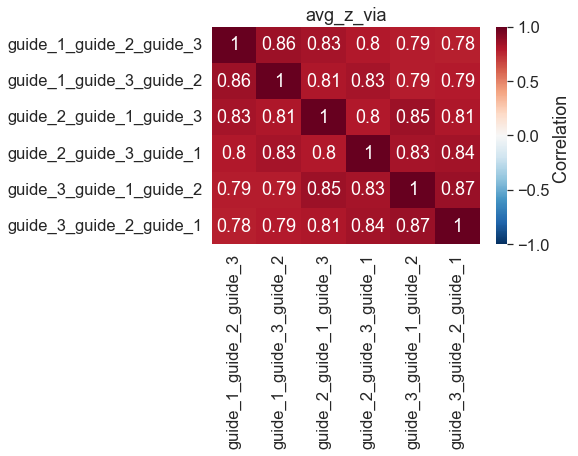

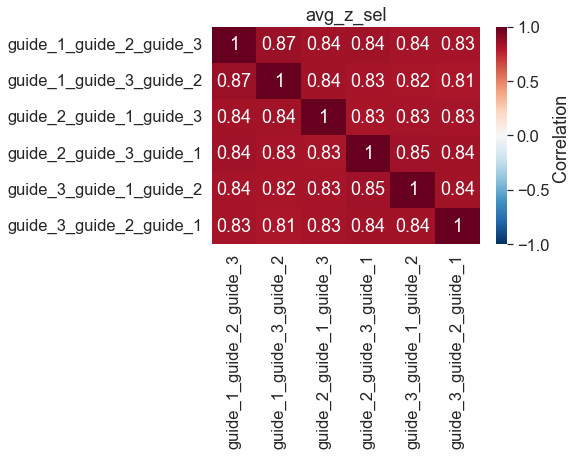

In [55]:
for z in ['avg_z_via','avg_z_sel']:
    
    check = validated_guide_3_score[['Gene Symbol', z,  'order', 'Design window', 'Set']]
    fig, ax = plt.subplots(figsize=(6,4))
    check['label'] = check['Gene Symbol']+' '+check['Design window'] + '_' +check['Set']

    ax = sns.heatmap(check.pivot("label", "order", z).dropna().corr('pearson') , vmin=-1, vmax=1, annot=True,  
                      cmap=gpp.diverging_cmap(), center = 0, 
                   cbar_kws={'label':'Correlation '})
    ax.set_title(z )
    ax.set(xlabel='', ylabel='')

    

# 4 Figure 5b

### Validated Single Guide

In [56]:
# average across p65 and VP64
single_guide['avg_z_via'] = single_guide[['z_vp64_via', 'z_p65_via']].mean(axis=1)
single_guide['avg_z_sel'] = single_guide[['z_vp64_sel', 'z_p65_sel']].mean(axis=1)
# filter for guides targeting high confidence genes
validate_1g = pd.merge(single_guide[['guide', 'g1', 'avg_z_via','avg_z_sel']], 
                      all_drugarm_validate[['Gene Direction','drugarm','g1']].drop_duplicates(), on = 'g1')

validate_1g['num_guide'] = 'one guide'


### Validated Dual Guide

In [57]:
#select dual guide construct
dual_guide = z_MELJUSO[(z_MELJUSO['g1'] != 'Filler') & (z_MELJUSO['g2'] != 'Filler') & (z_MELJUSO['g3'] == 'Filler')]
dual_guide = dual_guide[dual_guide['Construct IDs'].str.contains('GUIDE_INTERGENIC_SITE') == False]

# average across p65 and VP64
dual_guide['avg_z_via'] = dual_guide[['z_vp64_via', 'z_p65_via']].mean(axis=1)
dual_guide['avg_z_sel'] = dual_guide[['z_vp64_sel', 'z_p65_sel']].mean(axis=1)

# filter for guides targeting high confidence genes
validate_2g = pd.merge(dual_guide[['guide', 'g1', 'avg_z_via','avg_z_sel']], 
                      all_drugarm_validate[['Gene Direction','drugarm','g1']].drop_duplicates(), on = 'g1')
validate_2g['num_guide'] = 'two guide'


### Validated Trio Guide

In [58]:
#select trio guide construct
trio_guide = z_MELJUSO[(z_MELJUSO['g1'] != 'Filler') & (z_MELJUSO['g2'] != 'Filler') & (z_MELJUSO['g3'] != 'Filler')]
trio_guide = trio_guide[trio_guide['Construct IDs'].str.contains('GUIDE_INTERGENIC_SITE') == False]

# average across p65 and VP64
trio_guide['avg_z_via'] = trio_guide[['z_vp64_via', 'z_p65_via']].mean(axis=1)
trio_guide['avg_z_sel'] = trio_guide[['z_vp64_sel', 'z_p65_sel']].mean(axis=1)

# # filter for guides targeting high confidence genes
validate_3g = pd.merge(trio_guide[['guide', 'g1', 'avg_z_via','avg_z_sel']], 
                      all_drugarm_validate[['Gene Direction','drugarm','g1']].drop_duplicates(), on = 'g1')
validate_3g['num_guide'] = 'three guide'


### Combining together

In [59]:
validate_123 = pd.concat([validate_1g, validate_2g, validate_3g])

In [60]:
validate_123.head()

guide     g1  avg_z_via  avg_z_sel Gene Direction  \
0  CCCCAAAGCGCAAGCAACTGAGA  UIMC1  -2.235894   1.227794    Sensitizing   
1  CCCAAAGCGCAAGCAACTGAGAC  UIMC1  -1.974940   0.567908    Sensitizing   
2  AGTCTCCGCGCGCTGCGCCTGCG  UIMC1  -0.815359  -0.411176    Sensitizing   
3  CCCCACAGCTATCTCTGAGTCTG  UIMC1  -2.059592   0.846533    Sensitizing   
4  AACTGCGCGGGAGGCGCTGACCG  UIMC1   0.858057   0.163571    Sensitizing   

     drugarm  num_guide  
0  Viability  one guide  
1  Viability  one guide  
2  Viability  one guide  
3  Viability  one guide  
4  Viability  one guide

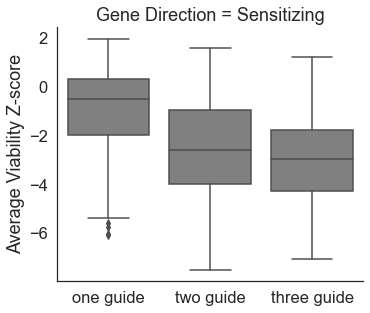

In [61]:

ax = sns.catplot(
    data=validate_123[validate_123['drugarm'] == 'Viability'], x='num_guide', y='avg_z_via',
    col='Gene Direction', kind='box', color= 'grey',col_wrap=2
)
ax.set(xlabel='', ylabel='Average Viability Z-score')


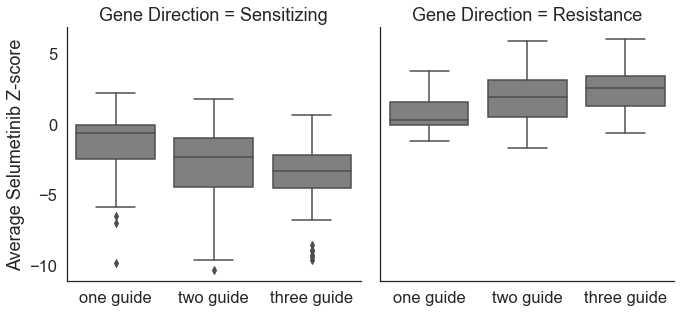

In [62]:

ax = sns.catplot(
    data=validate_123[validate_123['drugarm'] == 'Selumetinib'], x='num_guide', y='avg_z_sel', 
    col='Gene Direction', kind='box', col_wrap=2, color= 'grey'
)
ax.set(xlabel='', ylabel='Average Selumetinib Z-score')




# 5 Figure5 c 

In [63]:
sd_comp_single_guide = single_guide[['guide', 'g1', 'avg_z_via','avg_z_sel']].rename(columns = {'guide':'guide_1',
                                                                                              'g1': 'Construct IDs'})

dual_guide[['guide_1','guide_2']] = dual_guide['guide'].str.split(DR2,expand=True)[[0,1]]
sd_comp_dual_guide = dual_guide[['Construct IDs', 'avg_z_via','avg_z_sel','guide_1','guide_2']]

sd_comp_single_guide.columns = ['single_guide_' + col_name for col_name in sd_comp_single_guide.columns]    
sd_comp_dual_guide.columns = ['dual_guide_' + col_name for col_name in sd_comp_dual_guide.columns]    


In [64]:
sd_comp1 = pd.merge(sd_comp_dual_guide.rename(columns = {'dual_guide_guide_1':'guide_1'}),
                    sd_comp_single_guide[['single_guide_avg_z_via', 'single_guide_avg_z_sel', 'single_guide_guide_1']]
                    .rename(columns = {'single_guide_guide_1':'guide_1', 
                                       'single_guide_avg_z_via':'guide1_avg_z_via', 
                                       'single_guide_avg_z_sel':'guide1_avg_z_sel'}), 
                    on = 'guide_1')
sd_comp2 = pd.merge(sd_comp1.rename(columns = {'dual_guide_guide_2':'guide_2'}),
          sd_comp_single_guide[['single_guide_avg_z_via', 'single_guide_avg_z_sel', 'single_guide_guide_1']].rename(columns = {'single_guide_guide_1':'guide_2', 'single_guide_avg_z_via':'guide2_avg_z_via', 'single_guide_avg_z_sel':'guide2_avg_z_sel'}), 
                    on = 'guide_2')

In [65]:
sd_comp2[['g1', 'g2','g3']] =sd_comp2['dual_guide_Construct IDs'].str.split(';',expand=True)[[0,1,2]]
validate_sd_comp2 = pd.merge(sd_comp2, all_drugarm_validate[['Gene Direction', 'drugarm','g1']].drop_duplicates(), on = 'g1')
validate_sd_comp2.head()

dual_guide_Construct IDs  dual_guide_avg_z_via  dual_guide_avg_z_sel  \
0       PRDM1;PRDM1;Filler             -5.562270             -2.678410   
1       PRDM1;PRDM1;Filler             -1.941716             -1.282086   
2       PRDM1;PRDM1;Filler             -2.978737             -1.088882   
3       PRDM1;PRDM1;Filler             -1.353227             -1.065267   
4       PRDM1;PRDM1;Filler             -5.245617             -2.451275   

                   guide_1                  guide_2  guide1_avg_z_via  \
0  CCCCAGATTGCTAGCACAGCCGC  ATGTTGAAATACACATGCGAAGA         -5.316459   
1  TTAGCCACTCGGCTGCGCGAAGT  ATGTTGAAATACACATGCGAAGA          0.215529   
2  CCCCAGATTGCTAGCACAGCCGC  TTAGCCACTCGGCTGCGCGAAGT         -5.316459   
3  ATGTTGAAATACACATGCGAAGA  TTAGCCACTCGGCTGCGCGAAGT          0.852002   
4  CCCCAGATTGCTAGCACAGCCGC  AAGGCACTTAACCTCAACGCTTA         -5.316459   

   guide1_avg_z_sel  guide2_avg_z_via  guide2_avg_z_sel     g1     g2      g3  \
0         -0.270943          0.852002         -0.253139  PRDM1  PRDM1  Filler   
1         -0.214450          0.852002         -0.253139  PRDM1  PRDM1  Filler   
2         -0.270943          0.215529         -0.214450  PRDM1  PRDM1  Filler   
3         -0.253139          0.215529         -0.214450  PRDM1  PRDM1  Filler   
4         -0.270943         -2.082289         -0.464021  PRDM1  PRDM1  Filler   

  Gene Direction    drugarm  
0    Sensitizing  Viability  
1    Sensitizing  Viability  
2    Sensitizing  Viability  
3    Sensitizing  Viability  
4    Sensitizing  Viability

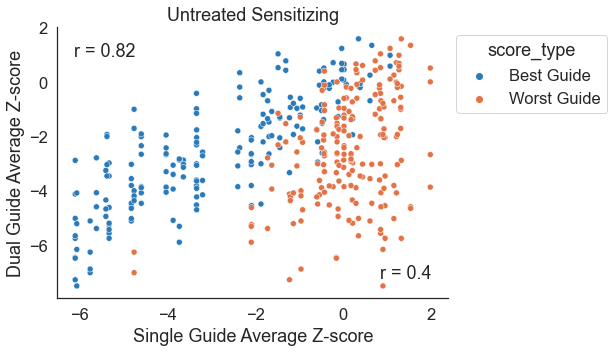

In [66]:
#untreated Sensitizing (depletion hits)
untreated_max_min = validate_sd_comp2[validate_sd_comp2['drugarm'] == 'Viability'][[ 'g1','guide_1', 'guide_2',
                                                                                    'dual_guide_avg_z_via','guide1_avg_z_via',
                                                                                    'guide2_avg_z_via','Gene Direction', 'drugarm']]
#best guide has low z-score and worst guide has high z-score
untreated_max_min['Best Guide'] = untreated_max_min[["guide1_avg_z_via", "guide2_avg_z_via"]].min(axis=1)
untreated_max_min['Worst Guide'] = untreated_max_min[["guide1_avg_z_via", "guide2_avg_z_via"]].max(axis=1)


fig, ax = plt.subplots(figsize=(7,5))
untreated_max_min_melt = untreated_max_min.melt(id_vars=['g1','guide_1', 'guide_2', 'dual_guide_avg_z_via', 'guide1_avg_z_via', 'guide2_avg_z_via', 'Gene Direction', 'drugarm'],
                         var_name='score_type', value_name='single guide avg z score via')
color_dict = dict({'Worst Guide':'#E37346',
                  'Best Guide':'#2b7bba'})

ax = sns.scatterplot(data=untreated_max_min_melt, 
                     x='single guide avg z score via' , y="dual_guide_avg_z_via", 
                     hue = 'score_type', palette=color_dict)

gpp.add_correlation(data=untreated_max_min_melt[untreated_max_min_melt['score_type'] == 'Best Guide'].dropna(),
                           y='dual_guide_avg_z_via', x='single guide avg z score via', method='pearson')
gpp.add_correlation(data=untreated_max_min_melt[untreated_max_min_melt['score_type'] == 'Worst Guide'].dropna(),
                           y='dual_guide_avg_z_via', x='single guide avg z score via', method='pearson', loc='lower right')
ax.set_title('Untreated Sensitizing')
ax.set(xlabel='Single Guide Average Z-score', ylabel='Dual Guide Average Z-score')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()


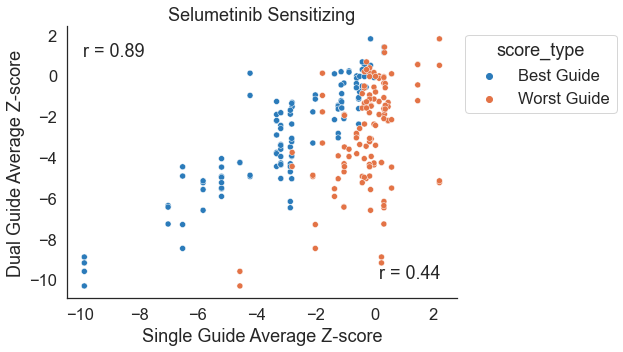

In [67]:
#sel Sensitize  (depletion hits)
sel_sen_max_min = validate_sd_comp2[(validate_sd_comp2['drugarm'] == 'Selumetinib') & 
                                    (validate_sd_comp2['Gene Direction'] == 'Sensitizing')][[ 'g1','guide_1', 
                                                                                             'guide_2','dual_guide_avg_z_sel','guide1_avg_z_sel',
                                                                                             'guide2_avg_z_sel','Gene Direction', 'drugarm']]
#best guide has low z-score and worst guide has high z-score

sel_sen_max_min['Best Guide'] = sel_sen_max_min[["guide1_avg_z_sel", "guide2_avg_z_sel"]].min(axis=1)
sel_sen_max_min['Worst Guide'] = sel_sen_max_min[["guide1_avg_z_sel", "guide2_avg_z_sel"]].max(axis=1)
color_dict = dict({'Worst Guide':'#E37346',
                  'Best Guide':'#2b7bba'})

fig, ax = plt.subplots(figsize=(7,5))
sel_sen_max_min_melt = sel_sen_max_min.melt(id_vars=['g1','guide_1', 'guide_2', 'dual_guide_avg_z_sel','guide1_avg_z_sel', 
                                                     'guide2_avg_z_sel','Gene Direction', 'drugarm'],
                         var_name='score_type', value_name='single guide avg z score sel senstize')
ax = sns.scatterplot(data=sel_sen_max_min_melt, 
                     x='single guide avg z score sel senstize', y= "dual_guide_avg_z_sel", 
                     hue = 'score_type', palette=color_dict)
gpp.add_correlation(data=sel_sen_max_min_melt[sel_sen_max_min_melt['score_type'] == 'Best Guide'].dropna(),
                           y='dual_guide_avg_z_sel', x='single guide avg z score sel senstize', method='pearson')
gpp.add_correlation(data=sel_sen_max_min_melt[sel_sen_max_min_melt['score_type'] == 'Worst Guide'].dropna(),
                           y='dual_guide_avg_z_sel', x='single guide avg z score sel senstize', method='pearson', loc='lower right')
ax.set_title('Selumetinib Sensitizing')
ax.set(xlabel='Single Guide Average Z-score', ylabel='Dual Guide Average Z-score')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()


In [68]:
#sel Resistant
sel_res_max_min = validate_sd_comp2[(validate_sd_comp2['drugarm'] == 'Selumetinib') & 
                                    (validate_sd_comp2['Gene Direction'] == 'Resistance')][[ 'g1','guide_1', 
                                                                                             'guide_2','dual_guide_avg_z_sel','guide1_avg_z_sel',
                                                                                             'guide2_avg_z_sel','Gene Direction', 'drugarm']]

#worst guide has low z-score and best guide has high z-score

sel_res_max_min['Worst Guide'] = sel_res_max_min[["guide1_avg_z_sel", "guide2_avg_z_sel"]].min(axis=1)
sel_res_max_min['Best Guide'] = sel_res_max_min[["guide1_avg_z_sel", "guide2_avg_z_sel"]].max(axis=1)

fig, ax = plt.subplots(figsize=(7,5))
sel_res_max_min_melt = sel_res_max_min.melt(id_vars=['g1','guide_1', 'guide_2', 'dual_guide_avg_z_sel','guide1_avg_z_sel', 
                                                     'guide2_avg_z_sel','Gene Direction', 'drugarm'],
                         var_name='score_type', value_name='single guide avg z score sel resistant')
color_dict = dict({'Worst Guide':'#E37346',
                  'Best Guide':'#2b7bba'})

ax = sns.scatterplot(data=sel_res_max_min_melt, 
                     x='single guide avg z score sel resistant', y= "dual_guide_avg_z_sel", 
                     hue = 'score_type', palette=color_dict)
ax.set_title('Selumetinib Resistant')
gpp.add_correlation(data=sel_res_max_min_melt[sel_res_max_min_melt['score_type'] == 'Best Guide'].dropna(),
                           y='dual_guide_avg_z_sel', x='single guide avg z score sel resistant', method='pearson')
gpp.add_correlation(data=sel_res_max_min_melt[sel_res_max_min_melt['score_type'] == 'Worst Guide'].dropna(),
                           y='dual_guide_avg_z_sel', x='single guide avg z score sel resistant', method='pearson', loc='lower right')
ax.set(xlabel='Single Guide Average Z-score', ylabel='Dual Guide Average Z-score')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
